# Bayesian Causal Modeling 

* [Causal analysis with PyMC: Answering "What If?" with the new do operator](https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/)

TLDR: `pymc` added the new `do` operator.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor as pt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# import the new functionality
from pymc import do, observe

In [2]:
SEED = 42

## Example: Estimating the impact of Google Ads with TV ads as a confounder

Model:

$$
\begin{aligned}
C &\sim \text{Normal}(0, 1)\\
Z &\sim \text{Bernoulli}(\text{InvLogit}(\beta_{z0} + \beta_{cz} C))\\
Y &\sim \text{Normal}(\beta_{y0} + \beta_{zy}Z + \beta_{cy}C, \sigma_y)
\end{aligned}
$$

Latent parameters $\theta$:

$$
\theta = \{\beta_{z0}, \beta_{y0}, \beta_{zy}, \beta_{zy}, \beta_{cz}, \sigma_y \}
$$

Define the model in a `pymc` model:

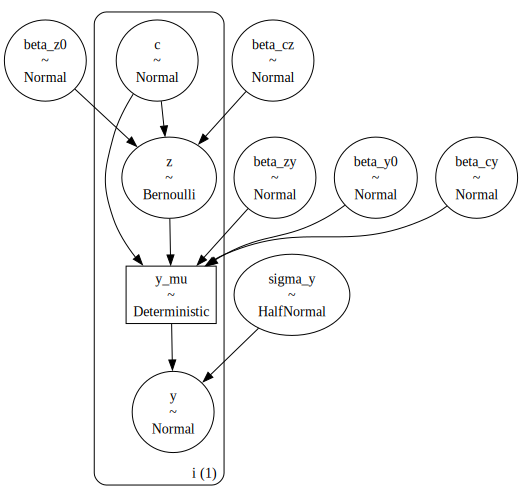

In [3]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- C -> Z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on Z -> Y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    z = pm.Bernoulli('z', p=pm.invlogit(beta_z0 + beta_cz * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

pm.model_to_graphviz(model_generative)    

## Simulating Data



In [4]:
true_ATE = 0.0

true_values = {
    "beta_z0": 0.0,
    "beta_y0": 0.0,
    "beta_cz": 1.5,
    "beta_zy": true_ATE,
    "beta_cy": 1.0,
    "sigma_y": 0.2,
}

model_simulate = do(model_generative, true_values)

Sample from this new model:

In [5]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=SEED)

observed = {
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten(),
    "z": simulate.prior["z"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("c", ascending=False)

Sampling: [c, y, z]


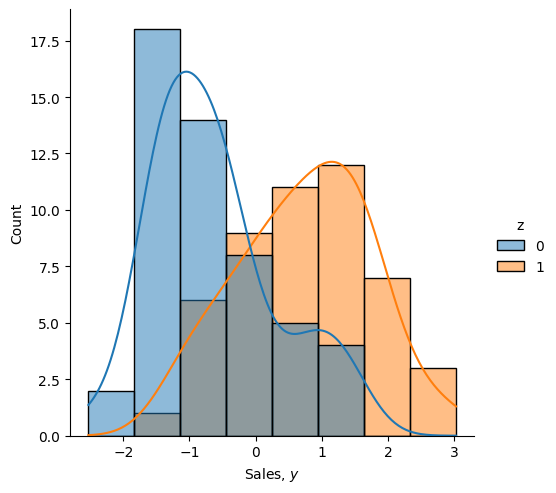

In [6]:
ax = sns.displot(data=df, x="y", hue="z", kde=True)
ax.set(xlabel="Sales, $y$");

Recall that the treatment $z$ is Google Ads but the true effect on sales is due to the confounder $C$ (TV ads). 

## Inference

In [7]:
# New function `observe()` 
model_inference = observe(model_generative, {"c": df["c"], "y": df["y"], "z": df["z"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))

In [8]:
with model_inference:
    idata = pm.sample(random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_cy, beta_cz, beta_z0, beta_zy, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


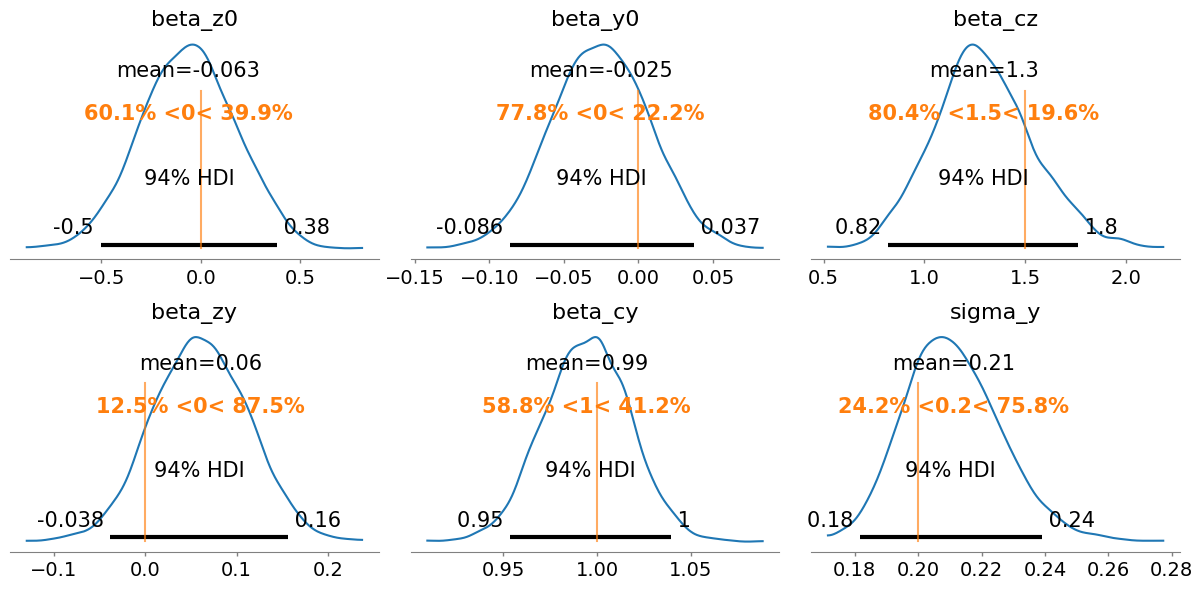

In [9]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

So the bayesian model we specified can recover the true (orange) underlying parameters based on the data.

# Simulating interventions with the `do` operator

In [10]:
# Replace c with its observed values
model_counterfactual = do(model_inference, {"c": df["c"]})

Next we can use the `do` operator:


In [11]:
# Generate models with Z=0 and Z=1
model_z0 = do(model_counterfactual, {"z": np.zeros(N, dtype="int32")}, prune_vars=True)
model_z1 = do(model_counterfactual, {"z": np.ones(N, dtype="int32")}, prune_vars=True)

That's two 'what-if' models. Now we can sample from both of these two 'what if' models and get the posterior predictives:

In [12]:
# Sample new sales data assuming Google Ads off: P(Y | c, do(z=0))
idata_z0 = pm.sample_posterior_predictive(
    idata,
    model=model_z0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)
# Sample new sales data assuming Google Ads on: P(Y | c, do(z=1))
idata_z1 = pm.sample_posterior_predictive(
    idata,
    model=model_z1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)

Sampling: []


Sampling: []


Given these two simulated interventions, we can calculate the ATE:

In [13]:
# calculate estimated ATE
ATE_est = idata_z1.predictions - idata_z0.predictions
print(f"Estimated ATE = {ATE_est.y_mu.mean().values:.2f}")

Estimated ATE = 0.06


But this is a point estimate, and the power of Bayesian stats is that we can look at the probability distribution of the outcomes.

In [14]:
percent = (idata.posterior["beta_zy"] / idata.posterior["beta_cy"]) * 100
print(
    f"Causal effect of Google Ads on sales is {percent.mean():.1f}% [{az.hdi(percent).x.data[0]:.1f}%,{az.hdi(percent).x.data[1]:.1f}%] of the effect of TV on sales"
)

Causal effect of Google Ads on sales is 6.1% [-3.6%,16.3%] of the effect of TV on sales
